<a href="https://colab.research.google.com/github/phaustin/ATSC_448/blob/master/lms_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.

/usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


21 batches of size 1

epoch 1

epoch 1 batch 0 nupdates 1

epoch 2

epoch 2 batch 0 nupdates 22

[1.23509793 1.06870369]


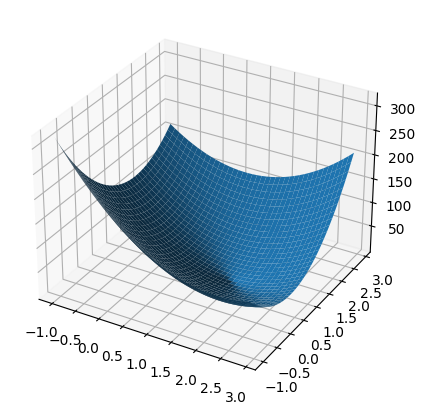

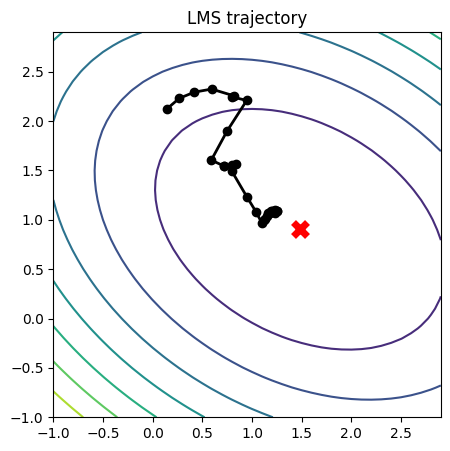

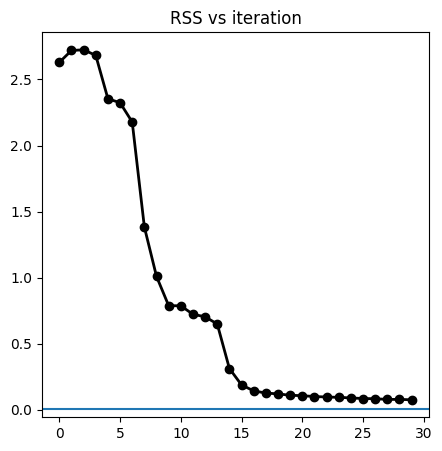

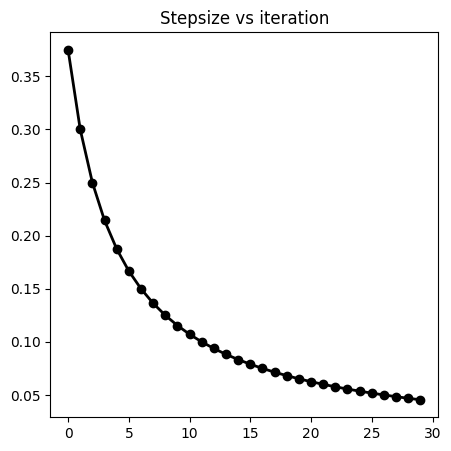

In [ ]:
# SGD on linear regression aka least mean squares
# Written by Duane Rich
# Based on https://github.com/probml/pmtk3/blob/master/demos/LMSdemoSimple.m


import numpy as np
import matplotlib.pyplot as plt

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml


# from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

plt.rcParams["figure.figsize"] = (5, 5)  # width x height

np.random.seed(0)
# Generating synthetic data:
N = 21
wTrue = np.array([1.45, 0.92])
X = np.random.uniform(-2, 2, N)
X = np.column_stack((np.ones(N), X))

y = wTrue[0] * X[:, 0] + wTrue[1] * X[:, 1] + np.random.normal(0, 0.1, N)


# Plot SSE surface over parameter space.
v = np.arange(-1, 3, 0.1)
W0, W1 = np.meshgrid(v, v)
SS = np.array([sum((w0 * X[:, 0] + w1 * X[:, 1] - y) ** 2) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
SS = SS.reshape(W0.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(W0, W1, SS)
pml.savefig("lmsSSE.pdf")
plt.draw()

# Mean SE with gradient and Hessian:
def LinregLossScaled(w, X, y):
    Xt = np.transpose(X)
    XtX = Xt.dot(X)
    N = X.shape[0]
    err = X.dot(w) - y
    f = np.mean(err * err)
    g = (1 / N) * Xt.dot(err)
    H = (1 / N) * XtX
    return f, g, H


# Starting point from to search for optimal parameters
w0 = np.array([-0.5, 2])

# Determine loss at optimal param values:
def funObj(w):
    out, _, _ = LinregLossScaled(w, X, y)
    return out


res = minimize(funObj, w0, method="L-BFGS-B")
wOpt = res.x
fopt = funObj(wOpt)
# fopt,_ ,_ = LinregLossScaled(wTrue, X, y)

# Options for stochastic gradient descent
opts = {}
opts["batchsize"] = 1
opts["verbose"] = True
opts["storeParamTrace"] = True
opts["storeFvalTrace"] = True
opts["storeStepTrace"] = True
opts["maxUpdates"] = 30
opts["eta0"] = 0.5
opts["t0"] = 3

# Breaks the matrix X and vector y into batches
def batchify(X, y, batchsize):
    nTrain = X.shape[0]
    batchdata = []
    batchlabels = []
    for i in range(0, nTrain, batchsize):
        nxt = min(i + batchsize, nTrain + 1)
        batchdata.append(X[i:nxt, :])
        batchlabels.append(y[i:nxt])
    return batchdata, batchlabels


def stochgradSimple(objFun, w0, X, y, *args, **kwargs):
    # Stochastic gradient descent.

    # Algorithm works by breaking up the data into batches. It
    # determines a gradient for each batch and moves the current
    # choice of parameters in that direction. The extent to which
    # we move in that direction is determined by our shrinking
    # stepsize over time.

    # Includes options for the batchsize, total number of sweeps over
    # the data (maxepoch), total number of batches inspected (maxUpdated,
    # whether the algo should print updates as it progresses, options
    # controlling what infomation we keep track of,and parameters to
    # determine how the step size shinks over time.

    # Default options
    batchsize = kwargs["batchsize"] if "batchsize" in kwargs else 10
    maxepoch = kwargs["maxepoch"] if "maxepoch" in kwargs else 500
    maxUpdates = kwargs["maxUpdates"] if "maxUpdates" in kwargs else 1000
    verbose = kwargs["verbose"] if "verbose" in kwargs else False
    storeParamTrace = kwargs["storeParamTrace"] if "storeParamTrace" in kwargs else False
    storeFvalTrace = kwargs["storeFvalTrace"] if "storeFvalTrace" in kwargs else False
    storeStepTrace = kwargs["storeStepTrace"] if "storeStepTrace" in kwargs else False
    t0 = kwargs["t0"] if "t0" in kwargs else 1
    eta0 = kwargs["eta0"] if "eta0" in kwargs else 0.1
    stepSizeFn = kwargs["stepSizeFn"] if "stepSizeFn" in kwargs else lambda x: eta0 * t0 / (x + t0)

    # Turn the data into batches
    batchdata, batchlabels = batchify(X, y, batchsize)
    num_batches = len(batchlabels)
    if verbose:
        print("%d batches of size %d\n" % (num_batches, batchsize))

    w = w0
    trace = {}
    trace["fvalMinibatch"] = []
    trace["params"] = []
    trace["stepSize"] = []

    # Main loop:
    nupdates = 1
    for epoch in range(1, maxepoch + 1):
        if verbose:
            print("epoch %d\n" % epoch)
        for b in range(num_batches):
            bdata = batchdata[b]
            blabels = batchlabels[b]
            if verbose and b % 100 == 0:
                print("epoch %d batch %d nupdates %d\n" % (epoch, b, nupdates))
            fb, g, _ = objFun(w, bdata, blabels, *args)
            eta = stepSizeFn(nupdates)
            w = w - eta * g  # steepest descent
            nupdates += 1
            if storeParamTrace:
                # Storing the history of the parameters may take a lot of space
                trace["params"].append(w)
            if storeFvalTrace:
                trace["fvalMinibatch"].append(fb)
            if storeStepTrace:
                trace["stepSize"].append(eta)
            if nupdates > maxUpdates:
                break
        if nupdates > maxUpdates:
            break
    return w, trace


w, trace = stochgradSimple(LinregLossScaled, w0, X, y, **opts)


def stochgradTracePostprocess(objFun, trace, X, y, *args):
    # This is to determine the losses for each set of parameters
    # chosen over the parameter path.
    fvalhist = []
    for t in range(len(trace)):
        fval, _, _ = objFun(trace[t], X, y, *args)
        fvalhist.append(fval)
    return fvalhist


print(w)
whist = np.asarray(trace["params"])

# Parameter trajectory
if True:
    fig, ax = plt.subplots()
    ax.set_title("LMS trajectory")
    CS = plt.contour(W0, W1, SS)
    plt.plot(wOpt[0], wOpt[1], "x", color="r", ms=10, mew=5)
    plt.plot(whist[:, 0], whist[:, 1], "ko-", lw=2)
    pml.savefig("lmsTraj.pdf")
    plt.draw()

# Loss values over the parameter path compared to the optimal loss.
if True:
    fvalhist = np.asarray(stochgradTracePostprocess(LinregLossScaled, trace["params"], X, y))
    fig, ax = plt.subplots()
    ax.set_title("RSS vs iteration")
    plt.plot(fvalhist, "ko-", lw=2)
    plt.axhline(fopt)
    pml.savefig("lmsRssHist.pdf")
    plt.draw()

# Stepsize graph if desired:
if True:
    stephist = np.asarray(trace["stepSize"])
    fig, ax = plt.subplots()
    ax.set_title("Stepsize vs iteration")
    plt.plot(stephist, "ko-", lw=2)
    pml.savefig("lmsStepSizeHist.pdf")
    plt.draw()

plt.show()

NameError: name 'stephist' is not defined

In [2]:
ax

NameError: name 'ax' is not defined